In [1]:
import os
import re
from lib_log_parse import load_parsed_logs, parse
from typing import Dict, List, Optional
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from typing import Tuple

sns.set_theme()

In [2]:
def cdf(series: pd.Series) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [3]:
path = "../data/2022-12-08_hydra_dial_down"

In [6]:
values = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    if os.path.exists(file_path + ".p"):
        print(f"Skipping: {file_path}")
        continue

    values += [[file_path]]

with mp.Pool() as pool:
    pool.map(parse, values)

Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-5.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-4.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-6.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-3.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-2.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-0.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-1-node-1.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-2.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-3.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-1.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-0.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-4.log
Skipping: ../data/2022-12-08_hydra_dial_down/nodes-list-fleet-2-node-5.log
Skipping: ../data/2022-12

In [4]:
files = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    files += [file_path]

pool = mp.Pool(mp.cpu_count())
results = pool.map(load_parsed_logs, list(map(lambda x: [x], files)))


In [5]:
def log_origin(origin: str) -> Optional[Tuple[int, int]]:
    match = re.search(r".*\/nodes-list-fleet-(\d)-node-(\d).log", origin)
    if match is None:
        match = re.search(r".*\/nodes-list-ignore-hydras-node-(\d).log", origin)
        if match is None:
            return None
        return 3, int(match.group(1))

    fleet = int(match.group(1))
    node = int(match.group(2))
    return fleet, node


def map_region(fleet: int, node: int) -> str:
    if fleet == 1:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_eu_nbg"
    elif fleet == 2:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_us_ash"
    elif fleet == 3:
        if node in log_no_to_region:
            return log_no_to_region[node]
        elif node == 6:
            return "hetzner_eu_nbg"
        elif node == 7:
            return "hetzner_us_ash"
    raise Exception(f"unknown fleet {fleet} node {node} combination")


def region_from_origin(origin: str) -> str:
    fleet, node = log_origin(origin)
    return map_region(fleet, node)


results_by_region = {}

for idx, f in enumerate(files):
    region = region_from_origin(f)

    if not region in results_by_region:
        results_by_region[region] = []
    results_by_region[region] += [results[idx][0]]

In [6]:
df_retrievals_dict = {
    "fleet": [],
    "node": [],
    "region": [],
    "with_hydras": [],
    "started_at": [],
    "overall_retrieval_duration": [],
    "dht_walks_duration": [],
    "find_first_provider_duration": [],
    "content_fetch_duration": [],
    "find_provider_queries_count": [],
    "has_error": [],
}

In [44]:
publications: List[Publication] = []
retrievals: List[Retrieval] = []
for parsed_log in results:
    for log in parsed_log:
        publications += log.publications
        retrievals += log.retrievals

# Remove all retrievals that are marked as invalid
retrievals = list(
    filter(lambda ret: not ret.marked_as_incomplete, retrievals))
retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

for ret in retrievals:
    if ret.stream_opened_at is None or ret.connected_at is None:
        print("skip", ret.stream_opened_at, ret.connected_at)
        continue

    fleet, node = log_origin(ret.origin)
    region = map_region(fleet, node)
    # region = region_from_origin(ret.origin)
    if region is None:
        raise Exception("AHH")

    df_retrievals_dict["started_at"] += [ret.dial_started_at]
    df_retrievals_dict["with_hydras"] += [fleet != 3]
    df_retrievals_dict["fleet"] += [fleet]
    df_retrievals_dict["node"] += [node]
    df_retrievals_dict["region"] += [region]
    df_retrievals_dict["has_error"] += [ret.done_retrieving_error is not None]

    overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
    # simulate peer record retrieval by adding the DHT walk duration
    overall_retrieval_duration += ret.get_dht_walk_duration()
    df_retrievals_dict["overall_retrieval_duration"] += [overall_retrieval_duration]

    # simulate peer record retrieval by adding the DHT walk duration
    dht_walks_duration = 2 * ret.get_dht_walk_duration()
    df_retrievals_dict["dht_walks_duration"] += [dht_walks_duration]

    df_retrievals_dict["find_first_provider_duration"] += [(
                                                                   ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()]
    df_retrievals_dict["content_fetch_duration"] += [(ret.done_retrieving_at - ret.dial_started_at).total_seconds()]
    df_retrievals_dict["find_provider_queries_count"] += [
        len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))]

df_retrievals = pd.DataFrame.from_dict(df_retrievals_dict)

skip None 2022-11-26 01:27:56.673828+00:00
skip None 2022-11-26 03:13:57.461092+00:00
skip None 2022-11-27 09:26:22.142936+00:00
skip None 2022-11-28 03:40:53.378387+00:00
skip None 2022-11-28 03:51:49.151898+00:00
skip None 2022-11-28 21:49:54.634930+00:00
skip None 2022-11-29 09:15:23.821383+00:00
skip None 2022-11-30 04:57:03.082503+00:00
skip None 2022-12-01 07:42:08.747063+00:00
skip None 2022-12-03 14:31:35.642540+00:00
skip None 2022-12-07 16:45:41.432303+00:00
skip None 2022-12-01 21:24:29.975931+00:00
skip None 2022-12-05 01:38:56.754089+00:00
skip None 2022-11-26 13:08:16.063403+00:00
skip None 2022-11-26 16:13:45.958209+00:00
skip None 2022-11-26 19:48:54.547618+00:00
skip None 2022-11-26 20:33:48.770438+00:00
skip None 2022-11-27 08:41:53.912341+00:00
skip None 2022-11-29 06:56:58.477133+00:00
skip None 2022-12-02 20:57:36.165682+00:00
skip None 2022-11-26 20:33:48.931369+00:00
skip None 2022-11-27 08:41:54.222476+00:00
skip None 2022-11-27 12:01:38.543387+00:00
skip None 2

In [45]:
len(df_retrievals)

426174

(0.0, 1.8)

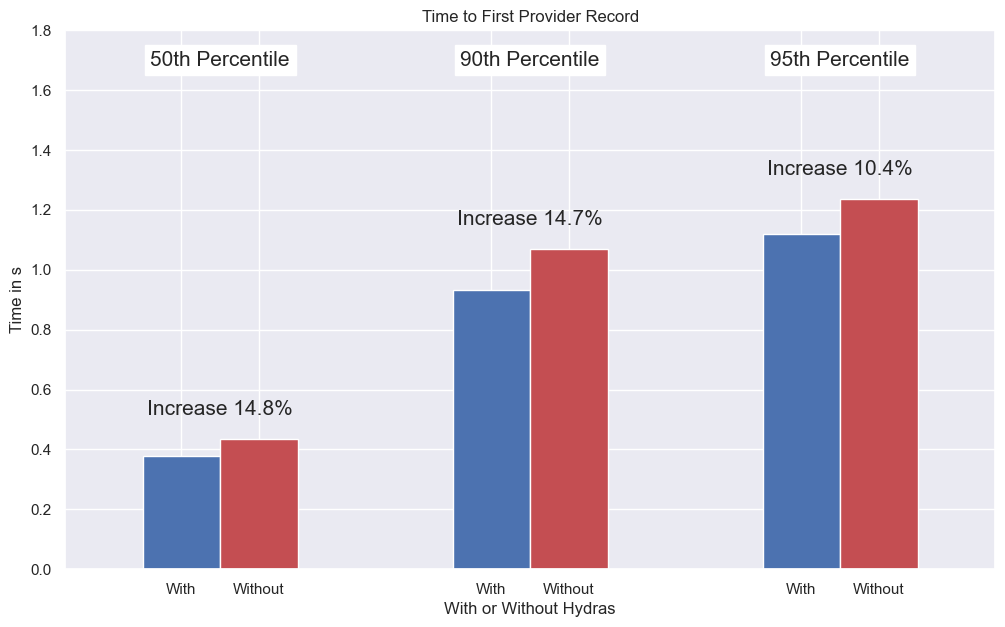

In [49]:
fig, ax = plt.subplots(figsize=[12, 7])

width = 0.25
xticks = []
labels = []
for i, percentile in enumerate([50, 90, 95]):
    dat = df_retrievals[df_retrievals["with_hydras"] == True]
    # dat = dat[dat["region"] != "hetzner_us_ash"]
    # dat = dat[dat["region"] != "hetzner_eu_nbg"]
    dat = dat[dat["started_at"] < "2022-12-01T17:30"]
    with_percentile = np.percentile(dat["find_first_provider_duration"], percentile)
    ax.bar(i - width / 2, with_percentile, width, label="With Hydras", color="b")

    dat = df_retrievals[df_retrievals["with_hydras"] == False]
    # dat = dat[dat["region"] != "hetzner_us_ash"]
    # dat = dat[dat["region"] != "hetzner_eu_nbg"]
    dat = dat[dat["started_at"] < "2022-12-01T17:30"]
    without_percentile = np.percentile(dat["find_first_provider_duration"], percentile)
    ax.bar(i + width / 2, without_percentile, width, label="Without Hydras", color="r")
    ax.text(i, without_percentile + 0.1, f"Increase {without_percentile / with_percentile - 1:.1%}", ha="center",
            va="center", size=15)

    ax.text(i, 1.7, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    xticks += [i - width / 2, i + width / 2]
    labels += ["With", "Without"]

ax.set_title(f"Time to First Provider Record")
ax.set_xlabel("With or Without Hydras")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 1.8)

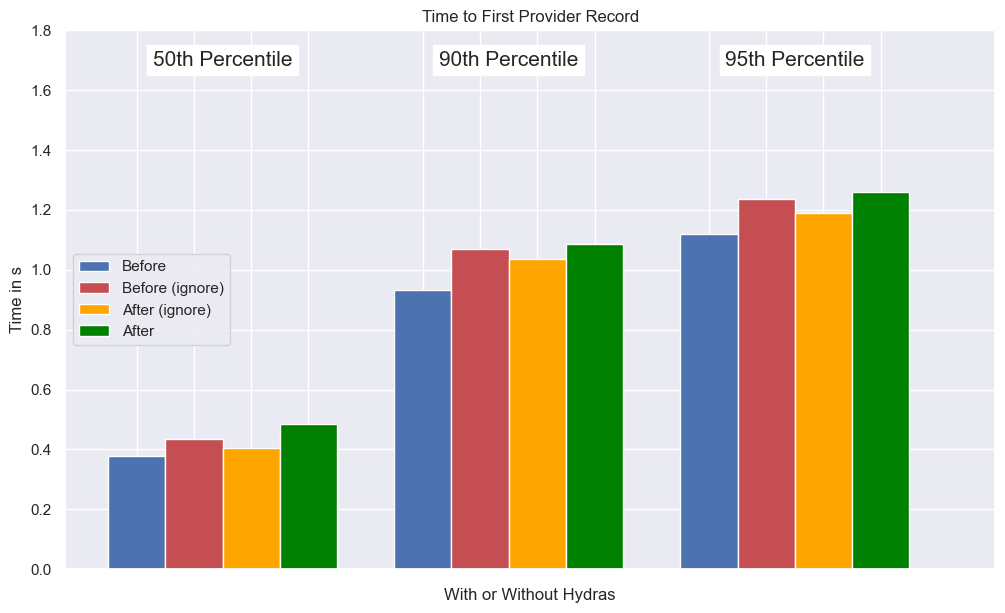

In [50]:
fig, ax = plt.subplots(figsize=[12, 7])

width = 0.2
xticks = []
labels = []
data = df_retrievals
# data = data[(data["region"] != "hetzner_us_ash") & (data["region"] != "hetzner_eu_nbg")]

bars_x_before = []
bars_x_before_ignore = []
bars_x_after_ignore = []
bars_x_after = []

bars_y_before = []
bars_y_before_ignore = []
bars_y_after_ignore = []
bars_y_after = []

for i, percentile in enumerate([50, 90, 95]):
    dat = data[data["with_hydras"] == True]
    dat = dat[dat["started_at"] < "2022-12-01T17:30"]
    bars_x_before += [i]
    bars_y_before += [np.percentile(dat["find_first_provider_duration"], percentile)]

    dat = data[data["with_hydras"] == False]
    dat = dat[dat["started_at"] < "2022-12-01T17:30"]
    bars_x_before_ignore += [i + width]
    bars_y_before_ignore += [np.percentile(dat["find_first_provider_duration"], percentile)]

    dat = data[data["with_hydras"] == False]
    dat = dat[dat["started_at"] >= "2022-12-01T17:30"]
    bars_x_after_ignore += [i + 2 * width]
    bars_y_after_ignore += [np.percentile(dat["find_first_provider_duration"], percentile)]

    dat = data[data["with_hydras"] == True]
    dat = dat[dat["started_at"] >= "2022-12-01T17:30"]
    bars_x_after += [i + 3 * width]
    bars_y_after += [np.percentile(dat["find_first_provider_duration"], percentile)]

    xticks += [i, i + width, i + 2 * width, i + 3 * width]
    labels += ["Before", "Before (ignore)", "After (ignore)", "After"]

    ax.text(i+1.5*width, 1.7, f"{percentile}th Percentile", ha="center", va="center", size=15,
        bbox=dict(fc="w", lw=1))

ax.bar(bars_x_before, bars_y_before, width, label="Before", color="b")
ax.bar(bars_x_before_ignore, bars_y_before_ignore, width, label="Before (ignore)", color="r")
ax.bar(bars_x_after_ignore, bars_y_after_ignore, width, label="After (ignore)", color="orange")
ax.bar(bars_x_after, bars_y_after, width, label="After", color="green")

ax.set_title(f"Time to First Provider Record")
ax.set_xlabel("With or Without Hydras")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, []*len(xticks))
ax.set_xlim(-0.25, 3)
ax.set_ylim(0, 1.8)
ax.legend(loc="center left")

(0.0, 1.8)

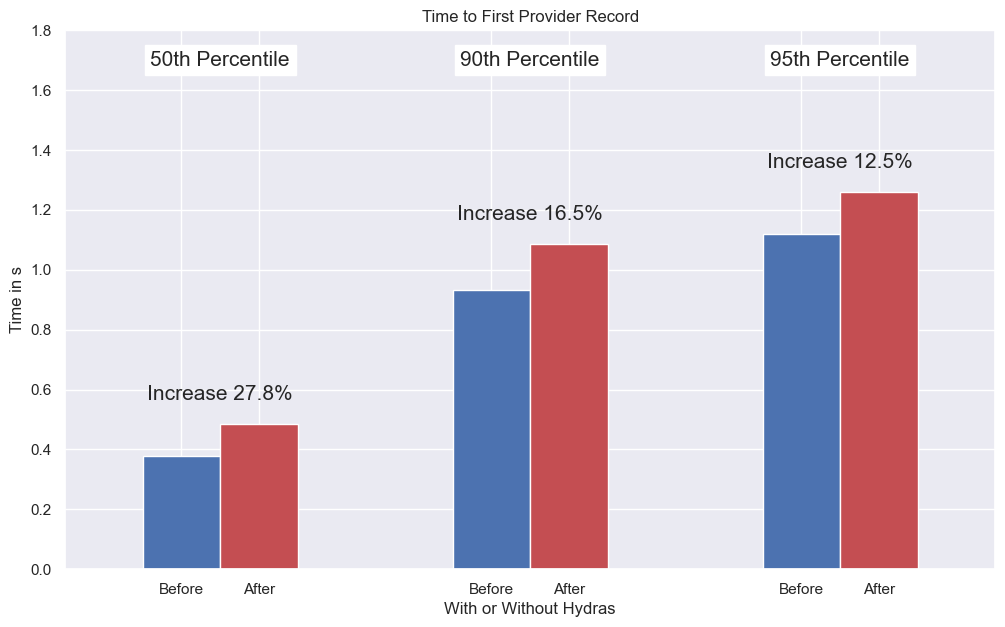

In [52]:
fig, ax = plt.subplots(figsize=[12, 7])

width = 0.25
xticks = []
labels = []

data = df_retrievals
data = data[data["with_hydras"]]

for i, percentile in enumerate([50, 90, 95]):
    dat = data[data["started_at"] < "2022-12-01T17:30"]
    before_percentile = np.percentile(dat["find_first_provider_duration"], percentile)
    ax.bar(i - width / 2, before_percentile, width, label="Before", color="b")

    dat = data[data["started_at"] >= "2022-12-01T17:30"]
    after_percentile = np.percentile(dat["find_first_provider_duration"], percentile)
    ax.bar(i + width / 2, after_percentile, width, label="After", color="r")
    ax.text(i, after_percentile + 0.1, f"Increase {after_percentile / before_percentile - 1:.1%}", ha="center",
            va="center", size=15)

    ax.text(i, 1.7, f"{percentile}th Percentile", ha="center", va="center", size=15,
            bbox=dict(fc="w", lw=1))
    xticks += [i - width / 2, i + width / 2]
    labels += ["Before", "After"]

ax.set_title(f"Time to First Provider Record")
ax.set_xlabel("With or Without Hydras")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 1.8)

(0.0, 1.6)

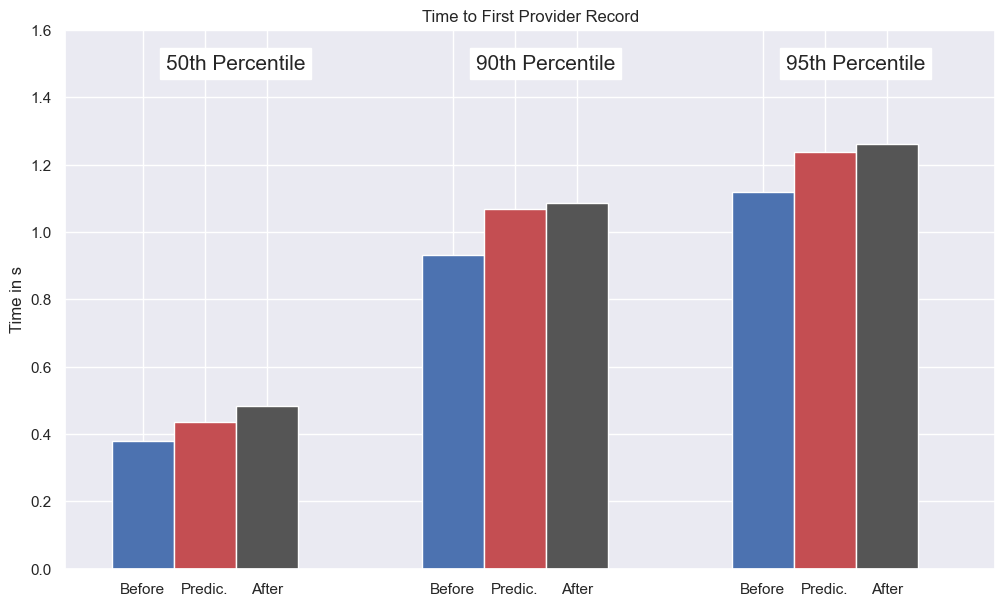

In [65]:
fig, ax = plt.subplots(figsize=[12, 7])

width = 0.2
xticks = []
labels = []
data = df_retrievals
# data = data[(data["region"] != "hetzner_us_ash") & (data["region"] != "hetzner_eu_nbg")]

bars_x_before = []
bars_x_before_ignore = []
bars_x_after_ignore = []
bars_x_after = []

bars_y_before = []
bars_y_before_ignore = []
bars_y_after_ignore = []
bars_y_after = []

for i, percentile in enumerate([50, 90, 95]):
    dat = data[data["with_hydras"] == True]
    dat = dat[dat["started_at"] < "2022-12-01T17:30"]
    bars_x_before += [i]
    bars_y_before += [np.percentile(dat["find_first_provider_duration"], percentile)]

    dat = data[data["with_hydras"] == False]
    dat = dat[dat["started_at"] < "2022-12-01T17:30"]
    bars_x_before_ignore += [i + width]
    bars_y_before_ignore += [np.percentile(dat["find_first_provider_duration"], percentile)]

    dat = data[data["with_hydras"] == True]
    dat = dat[dat["started_at"] >= "2022-12-01T17:30"]
    bars_x_after += [i + 2 * width]
    bars_y_after += [np.percentile(dat["find_first_provider_duration"], percentile)]

    xticks += [i, i + width, i + 2 * width]
    labels += ["Before", "Predic.", "After"]

    ax.text(i+1.5*width, 1.5, f"{percentile}th Percentile", ha="center", va="center", size=15,
        bbox=dict(fc="w", lw=1))

ax.bar(bars_x_before, bars_y_before, width, label="Before", color="b")
ax.bar(bars_x_before_ignore, bars_y_before_ignore, width, label="Predic.", color="r")
# ax.bar(bars_x_after_ignore, bars_y_after_ignore, width, label="After (ignore)", color="orange")
ax.bar(bars_x_after, bars_y_after, width, label="After", color="#555")

ax.set_title(f"Time to First Provider Record")
# ax.set_xlabel("With or Without Hydras")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.25, 2.75)
ax.set_ylim(0, 1.6)
# ax.legend(loc="center left")